# Logistic Regression Implementation

- Logistic regression is the **workhorse** of machine learning.
- Before deep learning era, logistic regression was the **default choice** for solving real life classification problems with hundreds and thousands of features.
- It works in binary, multi-class and multi-label classification set ups.

# Objective

- In this notebook, we will implement **binary logistic regression** from scratch and employ it for solving a couple of classification problems.
- In one of the setting, we have linearly separable classes and the other one has non-linear decision boundary between classes.
- The first problem can be addressed with basic logistic regression classifier, while the second will require additional step of **polynomial transformation** before using Logistic Regression.
- These cases should give an idea as to how to use Logistic Regression to solve classification problems in these two settings.

Lets import some basic python libraries that are required for the implementation:
- `numpy` for implementing components of Logistic Regression in the vectorized form.
- `matplotlib` and `seaborn` for visualization.
- `Math` and `Latex` libraries for proper rendering of mathematical expression in Markdown.

In [1]:
#@title [Import Libraries]
# Imported for proper rendering of Latex in notebook
from IPython.display import display, Math, Latex

import numpy as np

# Import for generating plots
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

We also set a random seed in otder to reproduce the same results across diferrent runs in this notebook.

In [2]:
np.random.seed(1234)

# Implementation

In the first part, we will implement **individual components** of binary logistic regression one by one:

## Model
- Logistic regression classifier calculates the condition probability of a sample, represented with a feature vector $x$, belonging to a class $1$ given the input $x$ which is represented as : $Pr(y=1 | x)$.
- It has 2 steps:
    1. **linear combination of features** and
    2. **sigmoid activation**


- Let's apply these steps on a single example to calculate is probability of belonging to class 1:
    1. The first step performs **linear combination of features** and obtain $z = w^T x$
    2. The second step applies **sigmoid or logistic activation** on $z$ to obtain the probability:
    $$Pr(y = 1| x) = \text{sigmoid} (z) = \frac{1}{1 + e^{-z}}$$

1. We make the above steps efficient by vectorizing the calculations. This enales us to compute the probabilites for several examples all at once: $z_{n \times 1} = X_{n \times (m+1)} w_{(m+1) \times 1}$.

    Here:
    - The feature matrix $X$ has shape $(n,m+1)$ (including the dummy feature)
    - The weight vector $w$ has $m+1$ components and
    - The resulting linear combination $z$ is a vector with $n$ components.

In [3]:
# Let's implement linear combination in vectorized form
def linear_combination(X:np.ndarray, w:np.ndarray) -> np.ndarray:
    '''Calculates linear combination of features

    The linear combination is calculated with the following vectorized form:
        z = Xw
    
    Args:
        X: feature matrix with shape (n, m+1)
        w: weight vector with shape (m+1,)
    
    Returns:
        Linear combination of features with shape (n,)
    '''
    return X@w

2. We vectorize **sigmoid or logistic activation** to obtain a vector of probability or activation: 
$$Pr(y_{n \times 1}=1|X_{n \times (m+1)}) = \text{sigmoid} (z_{n \times 1})$$

- The sigmoid function is applied on the vector $z$ with $n$ components and the result is a **probability** or an **activation vector** with $n$ components.

In [4]:
# Let's implement sigmoid function in a vectorized form
def sigmoid(z:np.ndarray) -> np.ndarray:
    '''Calculates sigmoid of linear combination of features contained in z.
    
    Args:
        z: list of floats
    
    Returns:
        List of outputs of sigmoid function
    '''
    return 1/(1 + np.exp(-z))

3. Lastly, we apply the vectorized prediction or inference funtion on activations to obtain a class label. Specifically, if **activation or probability > threshold**, then we label the sample with class $1$ or $0$.

In [5]:
def predict(X:np.ndarray, w:np.ndarray, threshold:float=0.5) -> np.ndarray:
    '''Predict class label for samples.
    
    The samples are represented with a bunch of features and are presented in the form of a feature matrix X.
    The class label is predicted as follows:
    * if sigmoid(Xw) > threshold, the sample is labeled with 1.
    * otherwise, the sample is labeled with 0.

    Args:
        X: feature vector of shape (n,m+1)
        w: weight vector of shape (m+1,)
        threshold: probability threshold for classification

    Returns:
        A list of class labels of shape (n,)
    '''
    return np.where(sigmoid(linear_combination(X,w)) > threshold, 1, 0)

## Loss Function

Next we implement Binary Cross Entropy (BCE) loss with regularization. The base loss without regularization can be obtained by setting the regularization rate $\lambda$ to $0$.

The generic form of loss is as follows:
$$\text{BCE} = \text{BCE on training examples} + \lambda * \text{regularization penalty}$$

Note that the **regularization rate** $\lambda$ **controls** the **amount of regularization penalty** to be used.
By setting $\lambda = 0$, we get **binary cross entropy loss** on the training.

First, we derive the BCE loss on training. We can define the loss the following way:
- Firstly, lets assume the model - $Pr(y=1|x) = h_w(x)$ and $Pr(y=0|x) = (1 - h_w(x))$.
- We can write this in the combined form as - $Pr(y|x; w) = (h_w(x))^y (1 - h_w(x))^{(1-y)}$.
- We can now, compute the maximum likelooh of the weight vector in the following way:
    - $L(w) = Pr(y_{n \times 1} | X_{n \times (m+1)}; w) = \prod_{i=1}^{n} Pr(y^{(i)}|x^{(i)}; w) = \prod_{i=1}^{n} (h_w(x^{(i)}))^{y^{(i)}} (1 - h_w(x^{(i)}))^{(1-y^{(i)})}$.
    - Taking `log` on both sides as maximizing the log likelihood is easier: $\log (L(w)) = \log (\prod_{i=1}^{n} (h_w(x^{(i)}))^{y^{(i)}} (1 - h_w(x^{(i)}))^{(1-y^{(i)})}) $, which gives us the log likelihood: $l(w) = \sum_{i = 1}^{n} y^{(i)} \log (h_w (x^{(i)})) + (1 - y^{(i)}) \log (1 - h_w(x^{(i)}))$.
    - We want to find the parameter $w$ such the that $l(w)$ is maximized.
    - Equivalently we can minimize the **negative log likelihood** (NLL) to maintain the uniformity with other algorithm. This can be considered a loss fucntion, also known as the **log likelihood loss** or **binary cross entropy loss**.
- So, $J(w) = - l(w)$.

We use $L_1$ and $L_2$ regularization in logistic regression.

With $L_1$ regularization, the loss function is calculated as follows:
$$J(w) = - (\sum_{i = 1}^{n} y^{(i)} \log (\text{sigmoid} (w^T x^{(i)})) + (1 - y^{(i)}) \log (1 - \text{sigmoid} (w^T x^{(i)}))) + \lambda ||w||_1 $$

With $L_2$ regularization, the loss function is calculates as follows:
$$J(w) = - (\sum_{i = 1}^{n} y^{(i)} \log (\text{sigmoid} (w^T x^{(i)})) + (1 - y^{(i)}) \log (1 - \text{sigmoid} (w^T x^{(i)}))) + \lambda ||w||_2^2 $$

In order to write the loss in vectorized form, we first calculate the term inside summation in vectorized form:
$$e = y \log (\text{sigmoid} (Xw)) + (1-y) \log (1 - \text{sigmoid} (Xw))$$

With this, the loss becomes:
$$J(w) = -1^T_{1 \times n} e_{n \times 1}$$

Adding $L_1$ penalty, we get:
$$J(w) = -1^T e + \lambda 1^T |w|$$

Adding $L_2$ penalty, we get:
$$J(w) = -1^T e + \lambda w^T w$$

The `loss` function implements vectorized loss calculation with actual label vector, activation vector, and $L_1$ and $L_2$ regularization rates.
> Set the regularization rate that is not needed to $0$.
> If we set the regularization rates suc that there sum is 1, we get **elastic net regularization**. In other words, for elastic net classifier, we have `l1_reg_rate + l2_reg_rate = 1`.

The loss function returns a scalar quantity that denotes the loss on all training examples for a particular choice of weight vectors.

In [6]:
def loss(y, sigmoid_vector, weight_vector, l1_reg_rate, l2_reg_rate):
    return (-1 * (np.sum(y*np.log(sigmoid_vector) + (1-y) * np.log(1 - sigmoid_vector))) 
    + l1_reg_rate * np.sum(np.abs(weight_vector)) 
    + l2_reg_rate * np.dot(np.transpose(weight_vector), weight_vector)
    )

In this notebook, we will only be focussing on $L_2$ regularization.

## Optimization

Next, we will implement optimization. For that we wil make use of iterative optimization techniques like gradient descent (GD), mini-batch gradient descent (MBGD) or stochastic gradient descent (SGD).

We will demonstrate Gradient Descent GD in this notebook, for which we adopt the GD implementation Linear Regression.

We need to modify the gradient update rule to make it suitable for logistic regression loss:
- **STEP 1:** Calculate the **gradient of loss function** and
- **STEP 2:** Scale the gradient with learning rate and use it for **updating the weight vector**.

### Gradient of loss function

The gradient of the loss function can be calculated (in vectorized form):
$$\frac{\partial J(w)}{\partial w} = X^T (\text{sigmoid} (Xw) - y) + \lambda w$$
where
- $\text{sigmoid} (Xw)$ is the sigmoid activation vector of samples and
- $y$ is the label vector
- $w$ is the weight vector
- $\lambda$ is the regularization rate.

It is implemented with `calculate_gradient` function that takes in feature matrix $X$, label vector $y$, weight vector $w$ and regularization rate $\lambda$ as arguments and efficiently calculates the gradient loss function w.r.t. the weight vector in the vectorized form.

In [7]:
def calculate_gradient(X:np.ndarray, y:np.ndarray, w:np.ndarray, reg_rate:float=0) -> np.ndarray:
    '''Calculates gradients of loss function w.r.t. weight vector on the training set.
    
    The gradient is calculated with the following vectorized operation:
        np.transpose(X) @ (sigmoid(Xw) - y) + λ w
    
    Args:
        X: Feature matrix for training data.
        y: Label vector for training data.
        reg_rate: Regularization rate.
    
    Returns:
        A vector of gradients.
    '''
    return np.transpose(X) @ (sigmoid(linear_combination(X,w)) - y) + reg_rate * w

As part of the implementation, we store the loss and weight vevtors in each GD step as a class member variable.
- The step-wise loss is used for plotting a learning curve in order to ensure that the model is trained as expected.
- The step-wise weight vector is useful in studying the **trajectory of gradient descent** in the loss landscape.

We do the same for SGD, MBGD implementations as well.

## Logistic Regression Class implementation

We combine these different components into a single python class with name `LogisticRegression`.

It has the following class member variables:
1. Weight Vector
2. Loss and Weight vectors in each GD, MBGD, SGD step.

In [8]:
class LogisticRegression(object):
    '''Logistic Regression Model
        y = sigmoid(X@w)
    '''
    def __init__(self):
        self.t0 = 20
        self.t1 = 1000

    def set_weight_vector(self, w):
        self.w = w
    
    def linear_combination(self, X:np.ndarray) -> np.ndarray:
        '''Calculates linear combination of features

        The linear combination is calculated with the following vectorized form:
            z = Xw
        
        Args:
            X: feature matrix with shape (n, m+1)
        
        Returns:
            Linear combination of features with shape (n,)
        '''
        return X @ self.w
    
    def sigmoid(self, z:np.ndarray) -> np.ndarray:
        '''Calculates sigmoid of linear combination of features contained in z.
        
        Args:
            z: list of floats
        
        Returns:
            List of outputs of sigmoid function
        '''
        return 1/(1 + np.exp(-z))
    
    def activation(self, X:np.ndarray) -> np.ndarray:
        '''Calculates sigmoid activation for logistic regression.
        
        The sigmoid activation is calculated with the following vectorized form:
            act = sigmoid(Xw)
        
        Args:
            X: feature matrix with shape (n, m+1)
        
        Returns:
            activation vector with shape(n,)
        '''
        return self.sigmoid(self.linear_combination(X))

    def predict(self, X:np.ndarray, threshold:float=0.5) -> np.ndarray:
        '''Predict class label for samples.
        
        The samples are represented with a bunch of features and are presented in the form of a feature matrix X.
        The class label is predicted as follows:
        * if sigmoid(Xw) > threshold, the sample is labeled with 1.
        * otherwise, the sample is labeled with 0.

        Args:
            X: feature vector of shape (n,m+1)
            threshold: float, optional
                probability threshold for binary classification (default is 0.5)

        Returns:
            A list of class labels of shape (n,)
        '''
        return (self.activation(X) > threshold).astype(int)

    def loss(self, X:np.ndarray, y:np.ndarray, reg_rate:float=0) -> float:
        '''Calculates Binary Cross Entropy Loss on the training set.
        
        Args:
            X: Feature matrix for training data.
            y: Label vector for training data.
            reg_rate: Regularization rate.
        
        Returns:
            L2 loss
        '''
        predicted_prob = self.activation(X)
        return (
            -1 * (np.sum(y * np.log(predicted_prob) + (1-y) * np.log(1 - predicted_prob)))
            + reg_rate * np.dot(np.transpose(self.w), self.w)
        )

    def calculate_gradient(self, X:np.ndarray, y:np.ndarray, reg_rate:float=0) -> np.ndarray:
        '''Calculate gradients of loss function w.r.t. weight vector on training set.

        Args:
            X: Feature matrix for given inputs
            y: Output label vector as known from the dataset (one-hot form)
            reg_rate: Rate of regularization
        
        Returns:
            A vector of gradients
        '''
        return np.transpose(X) @ (self.activation(X) - y) + reg_rate * self.w

    def update_weights(self, grad:np.ndarray, lr:float) -> np.ndarray:
        '''Update the weights based on the gradient of the loss function.

        Weight updates are carried out with the following formula:
            w_new := w_old - lr * grad
        
        Args:
            grad: Gradient of loss w.r.t w
            lr: Learning rate
        
        Returns:
            Updated weight vector
        '''
        return self.w - lr * grad

    # Dynamic learning rate
    def learning_schedule(self, t):
        return self.t0/(t + self.t1)

    # Gradient Descent
    def gd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, lr:float, reg_rate:float=0) -> np.ndarray:
        '''Estimates parameters of logistic regression model through gradient descent.
        
        Args:
            X: Feature matrix for training data
            y: Output label for training
            num_epochs: Number of training steps
            lr: Learning rate
            reg_rate: Rate of regularization
        
        Returns:
            Weight vector: Final weight vector
        '''
        self.w = np.zeros(X.shape[1])
        self.w_all = []
        self.err_all = []
        
        for i in np.arange(0, num_epochs):
            dJdW = self.calculate_gradient(X,y,reg_rate)
            self.w_all.append(self.w)
            self.err_all.append(self.loss(X,y,reg_rate))
            self.w = self.update_weights(dJdW, lr)
        
        return self.w

    # MBGD - Mini-Batch Gradient Descent
    def mbgd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, batch_size:int, reg_rate:float=0) -> np.ndarray:
        '''Estimates parameters of logistic regression model through mini-batch gradient descent.
        
        Args:
            X: Feature matrix for training data
            y: Output label for training
            num_epochs: No. of epochs (no. of times MBGD is done over the whole training set)
            batch_size: Size of each mini-batch, after which we update the weights
            reg_rate: Rate of regularization
        
        Returns:
            Weight vector: Final weight vector
        '''
        self.w = np.zeros(X.shape[1])
        self.w_all = []
        self.err_all = []
        mini_batch_id = 0

        for epoch in range(num_epochs):
            shuffled_indices = np.random.permutation(X.shape[0])
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]

            for i in range(0, X.shape[0], batch_size):
                mini_batch_id += 1
                
                # ith mini-batch
                Xi = X_shuffled[i:i + batch_size]
                yi = y_shuffled[i:i + batch_size]

                lr = self.learning_schedule(mini_batch_id)
                gradients = (2/ batch_size) * self.calculate_gradient(Xi, yi, reg_rate)

                self.w_all.append(self.w)
                self.err_all.append(self.loss(Xi, yi, reg_rate))
                self.w = self.update_weights(gradients, lr)
        
        return self.w
    
    # SGD - Stochastic Gradient Descent
    def sgd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, reg_rate:float=0) -> np.ndarray:
        '''Estimates parameters of Logisticregression model through stochastic gradient descent.
        
        Args:
            X: Feature matrix for training data
            y: Output label for training data vector
            num_epochs: No. of epochs (no. of times MBGD is done over the whole training set)
            reg_rate: Rate of regularization
        
        Returns:
            Weight vector: Final weight vector
        '''
        self.w = np.zeros(X.shape[1])
        self.w_all = []
        self.err_all = []

        for epoch in range(num_epochs):
            for i in range(X.shape[0]):
                random_index = np.random.randint(X.shape[0])
                Xi = X[random_index:random_index+1]
                yi = y[random_index:random_index+1]

                lr = self.learning_schedule(epoch * X.shape[0] + i)
                gradients = 2 * self.calculate_gradient(Xi, yi, reg_rate)

                self.w_all.append(self.w)
                self.err_all.append(self.loss(Xi,yi,reg_rate))
                self.w = self.update_weights(gradients, lr)
        
        return self.w


# Demo 1: Logistic Regression for linearly separable binary classification

In the first experiment we will use logistic regression to learn decision boundary between two linearly separable classes.

**STEP 1:** As the first step, we will generate 2 linearly separable classes with 50 samples each. Each example is represented with two features.

In [9]:
#@title [Toy dataset creation]
def create_toy_data(add_outliers=False, add_class=False):
    '''
    Here we are generating 50 examples with 2 features each.
    
    If add_outliers=True, we add 5 more outlier examples.
    
    If add_class=True, we add 25 exaamples more of the third class type, making the total no. of samples to 75.
    '''
    x0 = np.random.normal(size=50).reshape(-1,2) - 1
    x1 = np.random.normal(size=50).reshape(-1,2) + 1
    if add_outliers:
        x_1 = np.random.normal(size=10).reshape(-1,2) + np.array([5., 10.])
        return np.concatenate([x0, x1, x_1]), np.concatenate([np.zeros(25), np.ones(30)]).astype(np.int)
    if add_class:
        x2 = np.random.normal(size=50).reshape(-1,2) + 2
        return np.concatenate([x0, x1, x2]), np.concatenate([np.zeros(25), np.ones(25), 2 + np.zeros(25)]).astype(np.int)
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)

In [10]:
feature_matrix, label_vector = create_toy_data()
print(feature_matrix.shape, label_vector.shape)

(50, 2) (50,)


**STEP 2:** Add a dummy feature corresponding to the bias. We make use of polynomial feature transformation code that we have been using in the previous notebooks.

> The dummy feature can be added by performing polynomial transformation of degree 1.

In [11]:
#@title [Polynomial Transformation]
import itertools,functools

def get_combinations(x, degree):
    '''
    Return successive r-length combinations of elements in the iterable allowing individual elements to have successive repeats.

    combinations_with_replacement('ABC', 2) --> AA AB AC BB BC CC"
    '''
    return itertools.combinations_with_replacement(x,degree)

def compute_new_feature(items):
    '''
    reduce(function, sequence[, initial]) -> value

    Apply a function of two arguments cumulatively to the items of a sequence, from left to right, so as to reduce the sequence to a single value.

    For example: 
    reduce(lambda x, y: x+y, [1, 2, 3, 4, 5]) calculates ((((1+2)+3)+4)+5). 
    
    If initial is present, it is placed before the items of the sequence in the calculation, and serves as a default when the sequence is empty.

    reduce(lambda x,y: x*y, [1, 2, 3, 4, 5]) calculates ((((1*2)*3)*4)*5).
    '''
    return functools.reduce(lambda x, y: x*y, items)

def polynomial_transform(x, degree, logging=False):
    '''
    Steps for generating polynomial transformations of degree M ---
        
        1. Generate combination of input features of lengths = {0,1,...,M}.
        
        2. Perform multiplication operation between features to obtain the required new features.
    
    logging: Bool - True to print all the combinations and their products.
    '''
    
    # If 'x' is 1-dim, it is first converted to a feature matrix.
    # [1,2,3,4] to [[1],[2],[3],[4]]
    if x.ndim == 1:
        x = x[:,None]
    
    # Transpose of feature matrix
    x_t = x.transpose()

    # Populates 1's as first feature for each example, the degree 0 feature.
    features  = [np.ones(len(x))]

    if logging:
        print("Input: ",x)
    
    # for each degree d
    for d in range(1, degree+1):
        # generate combinations of degree d
        for x in get_combinations(x_t, d):
            # take product of no.s in x, and combine them into a single feature
            features.append(compute_new_feature(x))
            if logging:
                print(x,compute_new_feature(x), sep = ': ')
    
    if logging:
        print("Output: ", np.asarray(features).transpose())
    
    return np.asarray(features).transpose()

In [12]:
feature_matrix_bias = polynomial_transform(feature_matrix, degree=1)

**STEP 3:** Separate data into training and test sets.

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature_matrix_bias, label_vector)

In [14]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(37, 3) (37,)
(13, 3) (13,)


**STEP 4:** Let's visualize the training data to get an idea about its distribution.

Note that, it won't be possible to visualize real world datasets as there are many features. In this case, we have only two features in our dataset and hence we can visualize it in a 2D graph.

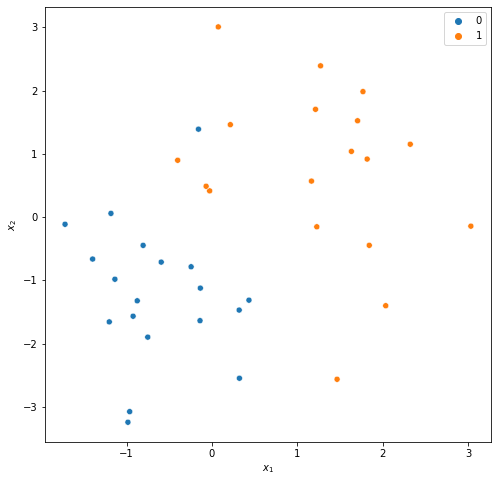

In [15]:
f = plt.figure(figsize=(8,8))
sns.scatterplot(data=X_train, x=X_train[:,1], y=X_train[:,2], hue=y_train)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

Note that the two classes are linearly separable with most points with in the boundary of their classes.

**STEP 5:** We are all set to train a logistic regression model onto this problem.
1. First we instantiate a logistic regression object.
2. We train the model on the training data via GD, MBGD, SGD and analyse the learning curve and model.

## Some helper functions

### Helper function for plotting learning curves

In [16]:
#@title [Learning Curve]
def plot_learning_curve(err):
    plt.figure()
    plt.plot(np.arange(len(err)), err, 'r-')
    plt.xlabel("Iteration no.")
    plt.ylabel("$J(w)$")
    plt.title("Learning curve")
    plt.show()

### Helper function for model visualization

In [17]:
#@title Model Visualization
def visualize_model(X_train, labels, lsc_obj, degree=1):

    f = plt.figure(figsize=(6,6))

    # compute xlim, ylim
    # First feature already has the dummy variable attached (because of polnomial transform)
    # min,max of feature 1
    x1_min = np.min(X_train[:,1])
    x1_max = np.max(X_train[:,1])
    # min,max of feature 2
    x2_min = np.min(X_train[:,2])
    x2_max = np.max(X_train[:,2])

    x1_test, x2_test = np.meshgrid(np.linspace(x1_min,x1_max, 100), np.linspace(x2_min,x2_max, 100))
    x_test = np.array([x1_test, x2_test]).reshape(2,-1).T
    x_test_poly = polynomial_transform(x_test, degree=degree)
    y_test_pred = lsc_obj.predict(x_test_poly)

    sns.scatterplot(data=X_train, x=X_train[:,1], y=X_train[:,2], hue=labels)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.xlim(x1_min,x1_max)
    plt.ylim(x2_min,x2_max)
    
    plt.contourf(x1_test, x2_test, y_test_pred.reshape(100,100), alpha=0.5, levels=np.linspace(0,1,3))

    plt.show()

## Fitting different Models

### Gradient Descent

In [18]:
log_reg_gd = LogisticRegression()
log_reg_gd.gd(X_train, y_train, num_epochs=1000, lr=1e-2, reg_rate=0)

array([-0.14559758,  4.43289743,  1.94514132])

### Learning Curve

Now, we examine the learning curve to make sure the model is able to learn with the current training set up. In cases, where the model is learning, the loss will reduce from one iteration to the next in gradient descent in a smooth manner.

We use the loss values stored during each step of Gradient Descent for plotting the learning curve.

Here is our learning curve:
- the iteration number is on the x-axis
- the loss is on the y-axis.

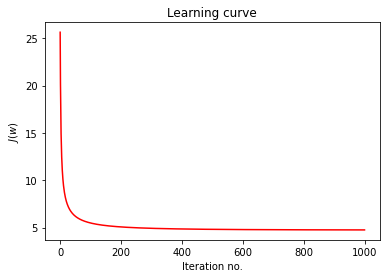

In [19]:
plot_learning_curve(log_reg_gd.err_all)

Note that the loss drops smoothly as we proceed with the GD.
> This is an ideal learning curve for the model training task.

Let's look at the final weight vector learnt by the model.

In [20]:
print("Weight vector: ", log_reg_gd.w)

Weight vector:  [-0.14559758  4.43289743  1.94514132]


### Model Visualization

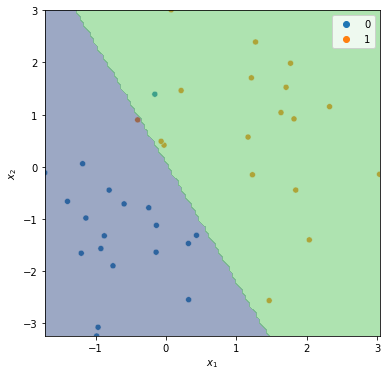

In [21]:
visualize_model(X_train, y_train, log_reg_gd)

As we can see above, our model has learnt a reasonable decision boundary that is able to separate most points from two classes.

We repeat the same for MBGD and SGD as well.

### Mini Batch Gradient Descent

In [22]:
log_reg_mbgd = LogisticRegression()
log_reg_mbgd.mbgd(X_train, y_train, num_epochs=100, batch_size=10, reg_rate=0)

array([-0.06465622,  1.65861172,  1.03777787])

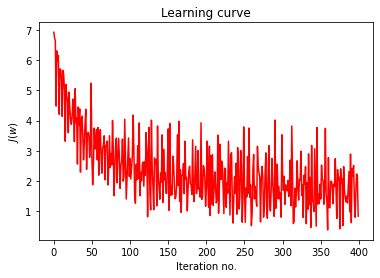

Weight vector:  [-0.06465622  1.65861172  1.03777787]


In [23]:
plot_learning_curve(log_reg_mbgd.err_all)
print("Weight vector: ", log_reg_mbgd.w)

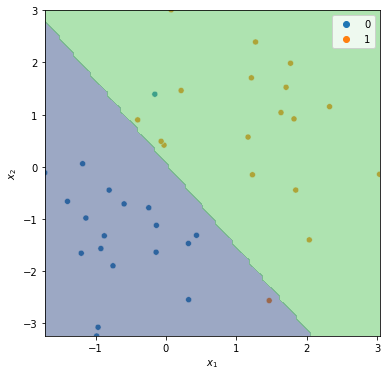

In [24]:
visualize_model(X_train, y_train, log_reg_mbgd)

### Stochastic Gradient Descent

In [25]:
log_reg_sgd = LogisticRegression()
log_reg_sgd.sgd(X_train, y_train, num_epochs=100, reg_rate=0)

array([-0.02644315,  3.00706384,  1.4517139 ])

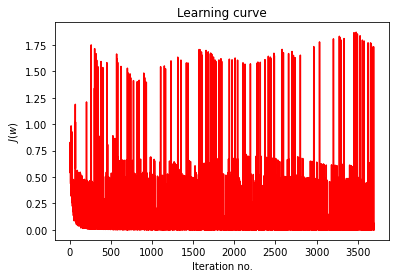

Weight vector:  [-0.02644315  3.00706384  1.4517139 ]


In [26]:
plot_learning_curve(log_reg_sgd.err_all)
print("Weight vector: ", log_reg_sgd.w)

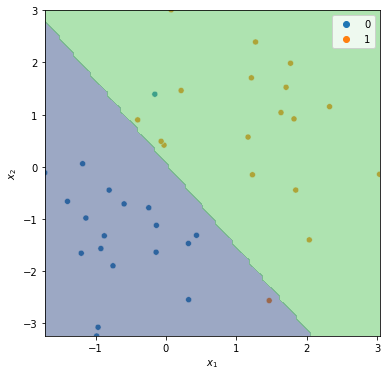

In [27]:
visualize_model(X_train, y_train, log_reg_mbgd)

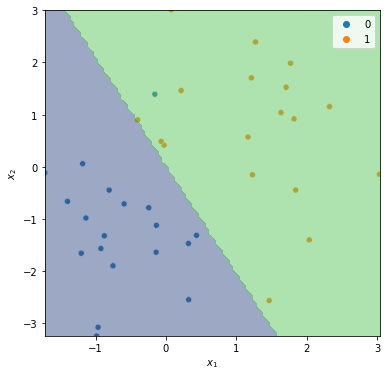

In [28]:
visualize_model(X_train, y_train, log_reg_sgd)

**STEP 6:** Model Evaluation

The next step is to use the model for making predictions on the new inputs. Let's predict labels on the test set - that was set aside for evaluating model performance.

### Gradient Descent

In [29]:
y_test_hat = log_reg_gd.predict(X_test)

We compare these predictions with the actual labels and generate a classification report that includes several metrics like confusion matrix, precision, recall, F1-score, accuracy etc.

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.78      1.00      0.88         7

    accuracy                           0.85        13
   macro avg       0.89      0.83      0.84        13
weighted avg       0.88      0.85      0.84        13



Note, our gradient descent classifier has `precision` of `0.78`, `recall` of `1.00` and `f1-score` of `0.88` on class label `1`.

### Mini Batch Gradient Descent

In [31]:
from sklearn.metrics import classification_report
y_test_hat = log_reg_mbgd.predict(X_test)
print(classification_report(y_test, y_test_hat, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.78      1.00      0.88         7

    accuracy                           0.85        13
   macro avg       0.89      0.83      0.84        13
weighted avg       0.88      0.85      0.84        13



### Stochastic Gradient Descent

In [32]:
from sklearn.metrics import classification_report
y_test_hat = log_reg_sgd.predict(X_test)
print(classification_report(y_test, y_test_hat, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.78      1.00      0.88         7

    accuracy                           0.85        13
   macro avg       0.89      0.83      0.84        13
weighted avg       0.88      0.85      0.84        13



# Demo 2: Polynomial Logistic Regression for non-linear binary classification

In this second demonstation, we will use logistic regression to fit a circular decision boundary between two classes.

**STEP 1:** For this demonstration, we will generate samples from two classes such that theu are separated by a circular decision boundary. We make use of the `make_circles` method from `sklearn.datasets` module for that. 

In [33]:
from sklearn.datasets import make_circles
feature_matrix, label_vector = make_circles()

In [34]:
print(feature_matrix.shape, label_vector.shape)

(100, 2) (100,)


**STEP 2:** As the next step, we will make use of the polynomial feature transformation to transform the features of polynominals to the desired degree.

**Note:**
- Generally we would not have an idea about an appropriate degree for polynomial transformation in a reak world problem setting.
- For, that we perform hyperparameter search to determine the right degree for polynomial transformation. (Using `GridSearchCV`, `RandomizedSearchCV` or other methods)
- Another option is to use model diagnostic tools- in case the model is underfitting, we can make the model fit better by increasing the degree of the polynomial. On the other hand, if the model is overfitting, we can either reduce the degree of the polynomial or increase the regularization penalty.

We use `polynomial_transform` with `degree=2` for transforming input features into the second order polynomial features.

In [35]:
features_poly_matrix = polynomial_transform(feature_matrix, degree=2)

This results in more features. Let's look at the shape of the feature matrix before and after transformation.

In [36]:
print(feature_matrix.shape, features_poly_matrix.shape)

(100, 2) (100, 6)


The four additional features are as follows:
1. Dummy feature corresponding to bias. It is set to 1.
2. Squares of the original features - that adds two more features: $x_1^2, x_2^2$.
3. One more feature corresponding to interaction between two features: $x_1 x_2$.

In [37]:
feature_matrix[:5]

array([[ 0.63742399, -0.77051324],
       [ 0.5831749 ,  0.54763768],
       [-0.92977649, -0.36812455],
       [ 0.63742399,  0.77051324],
       [-0.70104534,  0.38540294]])

In [38]:
features_poly_matrix[:5]

array([[ 1.        ,  0.63742399, -0.77051324,  0.40630934, -0.49114363,
         0.59369066],
       [ 1.        ,  0.5831749 ,  0.54763768,  0.34009297,  0.31936855,
         0.29990703],
       [ 1.        , -0.92977649, -0.36812455,  0.86448431,  0.34227355,
         0.13551569],
       [ 1.        ,  0.63742399,  0.77051324,  0.40630934,  0.49114363,
         0.59369066],
       [ 1.        , -0.70104534,  0.38540294,  0.49146457, -0.27018494,
         0.14853543]])

Note that the second and third feature are the original input features, whereas the first, fourth, fifth and sixth features are newly added features during transformation.

**STEP 3:** Split the training set consisting of transformed feature matrix label vector into train and test sets.

For this- we will make use of `train_test_split` util from `sklearn.model_selection`.

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_poly_matrix, label_vector)

In [40]:
print(X_train.shape, X_test.shape)

(75, 6) (25, 6)


**STEP 4:** We plot the training data in the original featre space and check its distribution.

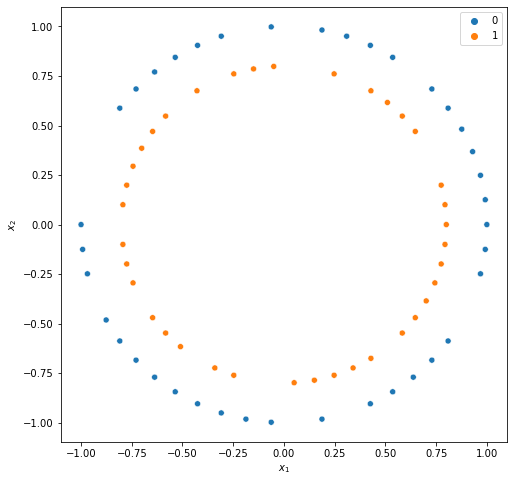

In [41]:
f = plt.figure(figsize=(8,8))
sns.scatterplot(data=X_train, x=X_train[:,1], y=X_train[:,2], hue=y_train)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

**STEP 5:** Train logistic regression model on the training set and visulize the model and the learning curves.

We perform this step individually for GD, MBGD and SGD.

### Gradient Descent

In [44]:
log_reg_gd = LogisticRegression()
log_reg_gd.gd(X_train, y_train, num_epochs=10000, lr=1e-2, reg_rate=0)

array([ 2.02615834e+01, -6.37927885e-02, -1.81908023e-02, -2.46394308e+01,
       -3.53230237e-01, -2.49474060e+01])

We make use of the loss values stores during each step of GD for plotting the learning curve.

Here is our learning curve:
- x-axis shows the no. of iterations.
- y-axis shows the variation of loss.

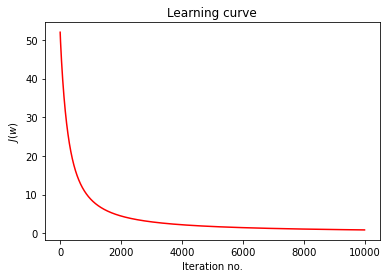

In [45]:
plot_learning_curve(log_reg_gd.err_all)

We will visualize the decision boundary learnt by the logistic regression classifier.

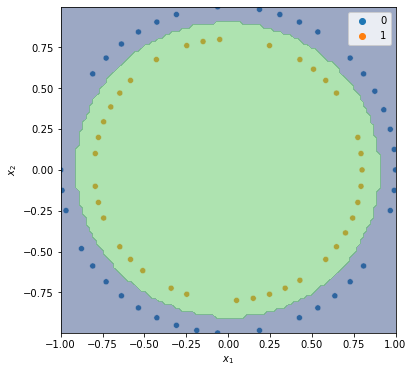

In [46]:
visualize_model(X_train, y_train, log_reg_gd, degree=2)

As we can see, the model has learnt the circular decision boundary.

Note: We are able to fit such a decision boundary due to the polynomial transformation of degree 2.

We repeat the same steps for MBGD and SGD as well.

### Mini Batch Gradient Descent

In [67]:
log_reg_mbgd = LogisticRegression()
log_reg_mbgd.mbgd(X_train, y_train, num_epochs=2500, batch_size=10, reg_rate=0)

array([ 2.56062114, -0.09955667, -0.02780291, -3.01176449, -0.52340628,
       -3.48851049])

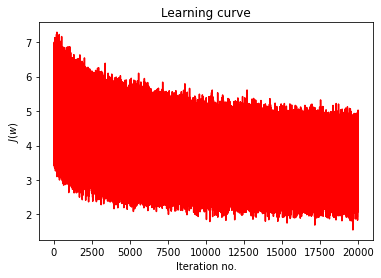

In [68]:
plot_learning_curve(log_reg_mbgd.err_all)

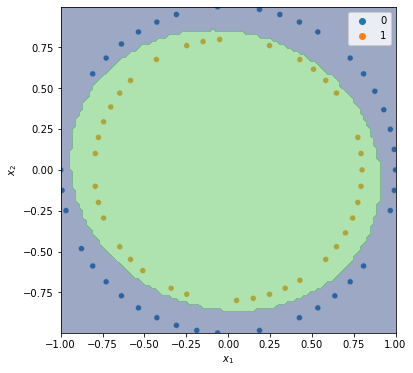

In [69]:
visualize_model(X_train, y_train, log_reg_mbgd, degree=2)

### Stochastic Gradient Descent

In [65]:
log_reg_sgd = LogisticRegression()
log_reg_sgd.sgd(X_train, y_train, num_epochs=500, reg_rate=0)

array([ 3.15951863, -0.08747402, -0.05103097, -3.75449642, -0.52648139,
       -4.20206671])

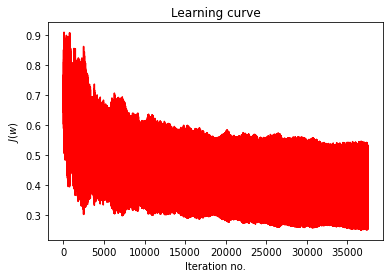

In [66]:
plot_learning_curve(log_reg_sgd.err_all)

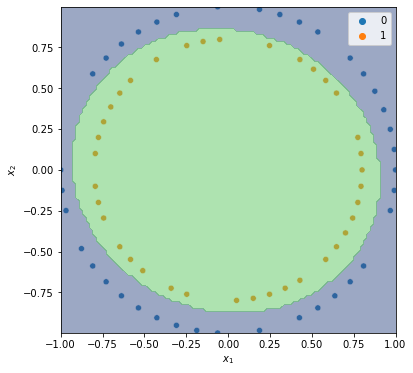

In [70]:
visualize_model(X_train, y_train, log_reg_sgd, degree=2)

**STEP 6:** Model Evaluation

The next step is to use the model for making predictions on new inputs.

Let's predict labels on the test set - that we set aside for evaluating model performance.

### Gradient Descent

In [71]:
y_test_hat = log_reg_gd.predict(X_test)

We compare these predictions with the actual labels and generate a classification report that includes several metrics like confusion matric, precision, recall, F1-score, accuracy etc.

In [72]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        13

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



**Note:** We have a perfect classifir here. It was a toy-setting- however such a thing may not be possible on the real world dataset.

### Mini Batch Gradient Descent

In [73]:
from sklearn.metrics import classification_report
y_test_hat = log_reg_mbgd.predict(X_test)
print(classification_report(y_test, y_test_hat, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        13

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



### Stochastic Gradient Descent

In [74]:
from sklearn.metrics import classification_report
y_test_hat = log_reg_sgd.predict(X_test)
print(classification_report(y_test, y_test_hat, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        13

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



# Logistic Regression Loss Surface Visualization

Here is the step by step process to generate this visualization:
1. Generate a grid of weights- $w_1$ and $w_2$.
2. For each point on the grid, calculate cross entropy loss on the fixed training set.
3. Plot contour of weights and loss.

The basic idea here is to calculate loss for a given weight vector on a fixed estimator and training set.

In [75]:
from matplotlib import cm # Colormaps
from matplotlib.colors import colorConverter, ListedColormap

We nee to instatiate a logistic regression estimator for cross entropy calculation.

In [76]:
log_reg_vis = LogisticRegression()

We also need training data for calculation of loss for a given weight vector.

In [80]:
feature_matrix, label_vector = create_toy_data()
feature_matrix_bias = polynomial_transform(feature_matrix, degree=1)
X_train, X_test, y_train, y_test = train_test_split(feature_matrix_bias, label_vector, test_size=0.2)

In [81]:
print(X_train.shape)

(40, 3)


Next we generate a grid of 25 weights.

In [84]:
point_count = 25

In [85]:
w1 = np.linspace(-5, 5, num=point_count)
w2 = np.linspace(-5, 5, num=point_count)
w1_list, w2_list = np.meshgrid(w1,w2) # generate the grid

Calculate the loss at each point on the grid.

In [86]:
loss = np.zeros((point_count, point_count)) # Initialize the loss matrix

# Fill the loss matrix for each combination of weights
for i in range(point_count):
    for j in range(point_count):
        weight_vector = np.array([0, w1_list[i,j], w2_list[i,j]])
        log_reg_vis.set_weight_vector(weight_vector)
        loss[i,j] = log_reg_vis.loss(X_train, y_train, reg_rate=0)

Now, we plot the loss surface.

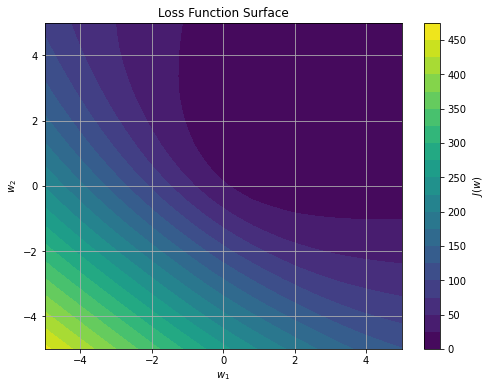

In [89]:
# Plot the loss function surface

plt.figure(figsize=(8,6))
plt.contourf(w1_list, w2_list, loss, 20, cmap=cm.viridis)
cbar = plt.colorbar()
cbar.ax.set_ylabel("$J(w)$")
plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.title("Loss Function Surface")
plt.grid()
plt.show()

## Model Trajactory on Loss Surface

### Gradient Descent

In [96]:
log_reg_vis.gd(X_train, y_train, num_epochs=1000, lr=1e-2, reg_rate=0)

array([-0.23179098,  4.09042028,  2.32627146])

We make use of the weights stored during the gradient descent procedure.

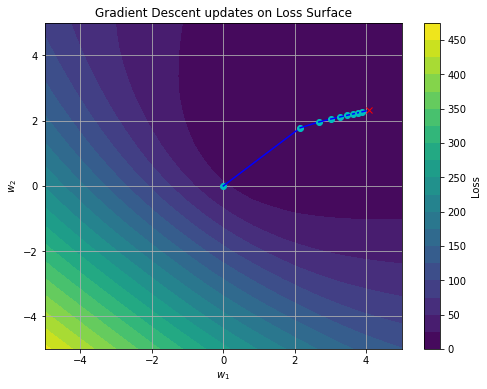

In [98]:
# First, plot the loss contours based on grid as drawn in the previous section.
plt.figure(figsize=(8,6))
plt.contourf(w1_list, w2_list, loss, 20, cmap=cm.viridis)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Loss")


# Plot weights after 100 iterations
for i in range(1, len(log_reg_vis.w_all), 100):
    if i+100 < len(log_reg_vis.w_all):
        w1 = log_reg_vis.w_all[(i-1)]
        w2 = log_reg_vis.w_all[(i+100)]

        # Plot the weight-loss values that represent the update
        plt.plot(w1[1], w1[2], marker='o', color='c') # Plots the weight-loss value
        plt.plot([w1[1], w2[1]], [w1[2], w2[2]], linestyle='-', color='b')

# Plot the last weight
w1 = log_reg_vis.w_all[-1]
plt.plot(w1[1], w1[2], marker='x', color='r')

# Show figure
plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.title("Gradient Descent updates on Loss Surface")
plt.grid()
plt.show()

### Mini Batch Gradient Descent

In [107]:
log_reg_vis.mbgd(X_train, y_train, num_epochs=250, batch_size=10, reg_rate=0)

array([0.08018585, 1.88665718, 1.66035654])

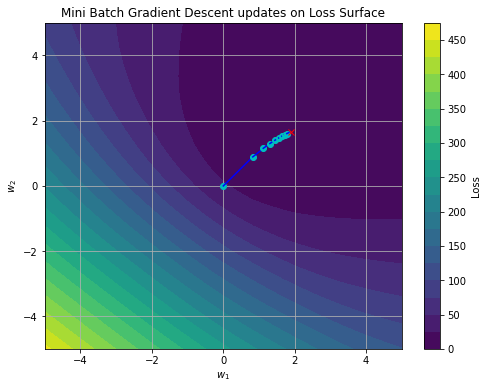

In [108]:
# First, plot the loss contours based on grid as drawn in the previous section.
plt.figure(figsize=(8,6))
plt.contourf(w1_list, w2_list, loss, 20, cmap=cm.viridis)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Loss")


# Plot weights after 100 iterations
for i in range(1, len(log_reg_vis.w_all), 100):
    if i+100 < len(log_reg_vis.w_all):
        w1 = log_reg_vis.w_all[(i-1)]
        w2 = log_reg_vis.w_all[(i+100)]

        # Plot the weight-loss values that represent the update
        plt.plot(w1[1], w1[2], marker='o', color='c') # Plots the weight-loss value
        plt.plot([w1[1], w2[1]], [w1[2], w2[2]], linestyle='-', color='b')

# Plot the last weight
w1 = log_reg_vis.w_all[-1]
plt.plot(w1[1], w1[2], marker='x', color='r')

# Show figure
plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.title("Mini Batch Gradient Descent updates on Loss Surface")
plt.grid()
plt.show()

### Stochastic Gradient Descent

In [109]:
log_reg_vis.sgd(X_train, y_train, num_epochs=100, reg_rate=0)

array([0.04129785, 2.5289713 , 1.81665705])

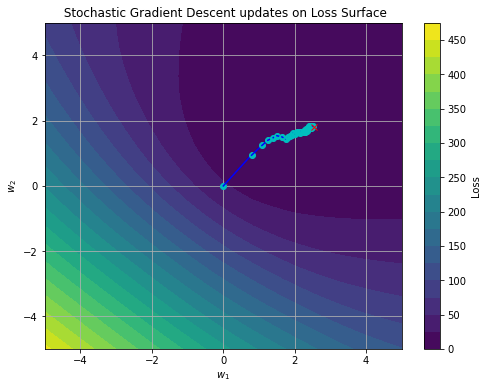

In [110]:
# First, plot the loss contours based on grid as drawn in the previous section.
plt.figure(figsize=(8,6))
plt.contourf(w1_list, w2_list, loss, 20, cmap=cm.viridis)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Loss")


# Plot weights after 100 iterations
for i in range(1, len(log_reg_vis.w_all), 100):
    if i+100 < len(log_reg_vis.w_all):
        w1 = log_reg_vis.w_all[(i-1)]
        w2 = log_reg_vis.w_all[(i+100)]

        # Plot the weight-loss values that represent the update
        plt.plot(w1[1], w1[2], marker='o', color='c') # Plots the weight-loss value
        plt.plot([w1[1], w2[1]], [w1[2], w2[2]], linestyle='-', color='b')

# Plot the last weight
w1 = log_reg_vis.w_all[-1]
plt.plot(w1[1], w1[2], marker='x', color='r')

# Show figure
plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.title(" Stochastic Gradient Descent updates on Loss Surface")
plt.grid()
plt.show()

# Summary

- We implemented **binary logistic regression** from scratch and employed it for solving a couple of classification problems.
- In one of the setting, we have linearly separable classes and the other one has non-linear decision boundary between classes.
- The first problem could be addressed with basic logistic regression classifier, while the second required additional step of **polynomial transformation** before using Logistic Regression.
- We also analysed the learning curves of individual models of iterative optimization, i.e. Gradient Descent, Mini Batch Gradient Descent for both the linear and non-linear cases.
- We also visualized the decision boundaries, since we limited ourselves to only 2 features.
- We also evaluated their performance on the test set via various classification performance metrics.
- Finally we visualized the loss surface and saw the paths taken by each of the iterative optimization model separately.